In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytz
from datetime import datetime, timedelta
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Exploring the data

In [2]:
raw_df = pd.read_csv('../../data/releases/flat/releases.csv')

In [3]:
raw_df.shape

(39079, 27)

In [4]:
raw_df.head(2).T

,0,1
id,4582161,7962644
status,Accepted,Accepted
resource_url,https://api.discogs.com/releases/4582161,https://api.discogs.com/releases/7962644
title,Top Stars & Hits,The Cornerstone Player 013
artists_sort,Various,Various
num_for_sale,2,2
date_added,2013-05-20T05:20:24-07:00,2016-01-11T02:13:02-08:00
lowest_price,18.0,13.21
released,1978,2000
country,Netherlands,US


### Including only single release formats in the dataset

In [5]:
raw_df['format_names'] = raw_df.format_names.apply(ast.literal_eval)

In [6]:
raw_df = raw_df.loc[raw_df.format_names.str.len()==1]
raw_df['format_names'] = raw_df.format_names.str[0]

In [7]:
raw_df[['id', 'format_names']].groupby('format_names').nunique().sort_values('id', ascending=False).head(10)

,id
format_names,
CD,21993
Vinyl,7674
File,3807
CDr,1636
Cassette,1165
DVD,398
Shellac,144
VHS,97
Betacam SP,50


In [8]:
raw_df = raw_df.loc[raw_df.format_names.isin(['CD', 'Vinyl'])]

In [9]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29667 entries, 2 to 39078
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      29667 non-null  int64  
 1   status                  29667 non-null  object 
 2   resource_url            29667 non-null  object 
 3   title                   29667 non-null  object 
 4   artists_sort            29667 non-null  object 
 5   num_for_sale            29667 non-null  int64  
 6   date_added              29667 non-null  object 
 7   lowest_price            24019 non-null  float64
 8   released                26992 non-null  object 
 9   country                 28963 non-null  object 
 10  genres                  29667 non-null  object 
 11  styles                  23793 non-null  object 
 12  estimated_weight        29666 non-null  float64
 13  blocked_from_sale       29667 non-null  bool   
 14  artist_ids              29667 non-null

## Extracting item quantity

In [10]:
raw_df['vinyl_qty'] = raw_df.vinyl_qty.apply(ast.literal_eval).str[0]
raw_df['cd_qty'] = raw_df.cd_qty.apply(ast.literal_eval).str[0]

In [11]:
raw_df.vinyl_qty.unique()

array([ nan,   1.,   5.,   2.,   3.,   4.,  10.,  20.,   6.,   8.,   7.,
       104.])

In [12]:
raw_df.cd_qty.unique()

array([  1.,  nan,   2.,   3.,   4.,   6.,  24.,  10.,   5.,   8.,  12.,
        20.,   9.,  19.,  15.,  18.,  30., 500.,  23.,   7.,   0.])

## Extracting release year

In [13]:
raw_df['release_year'] = raw_df.released.str[:4]

In [14]:
raw_df['days_since_added'] = (datetime.now(tz=pytz.utc) - pd.to_datetime(raw_df.date_added, utc=True)).dt.days
raw_df['year_added'] = pd.to_datetime(raw_df.date_added, utc=True).dt.year

In [15]:
# raw_df['genres'] = raw_df.genres.apply(ast.literal_eval)
# raw_df['styles'] = raw_df.styles.apply(ast.literal_eval)

In [16]:
raw_df.head(3).T

,2,3,4
id,2418890,262771,19527100
status,Accepted,Accepted,Accepted
resource_url,https://api.discogs.com/releases/2418890,https://api.discogs.com/releases/262771,https://api.discogs.com/releases/19527100
title,A History Of Schema: Numero Due,Pink Mini Compilation,Forever Gold
artists_sort,Various,Various,Various
num_for_sale,0,18,1
date_added,2010-08-28T12:10:51-07:00,2004-06-07T16:55:30-07:00,2021-07-17T08:09:25-07:00
lowest_price,NaN,1.77,7.06
released,2007,2003-12-00,2007
country,Japan,Germany,Canada


## Inspecting columns

In [17]:
raw_df[['status', 'id']].groupby('status').count()

,id
status,
Accepted,29667


In [18]:
raw_df[['artists_sort', 'id']].groupby('artists_sort').count().sort_values('id', ascending=False).head(10)

,id
artists_sort,
Various,18902
Sarah Vaughan,412
"Who, The",348
Percy Sledge,158
Charlie Parker,115
"Dave Dee, Dozy, Beaky, Mick & Tich",71
Joni Mitchell,62
Mountain,56
Johnny Nash,52


In [19]:
raw_df[['country', 'id']].groupby('country').count().sort_values('id', ascending=False).head(10)

,id
country,
UK,5433
US,4551
Germany,3196
France,1725
Netherlands,1516
Europe,1498
Japan,1290
Italy,1190
Belgium,836


In [20]:
raw_df[['blocked_from_sale', 'id']].groupby('blocked_from_sale').count().sort_values('id', ascending=False).head(10)

,id
blocked_from_sale,
False,28800
True,867


## Plotting uni- and bi-variate distributions

In [21]:
raw_df.columns

Index(['id', 'status', 'resource_url', 'title', 'artists_sort', 'num_for_sale',
       'date_added', 'lowest_price', 'released', 'country', 'genres', 'styles',
       'estimated_weight', 'blocked_from_sale', 'artist_ids', 'label_ids',
       'distributor_ids', 'mastered_ids', 'format_names', 'vinyl_qty',
       'cd_qty', 'community_haves', 'community_wants',
       'community_rating_count', 'community_rating_avg', 'n_videos',
       'n_tracks', 'release_year', 'days_since_added', 'year_added'],
      dtype='object')

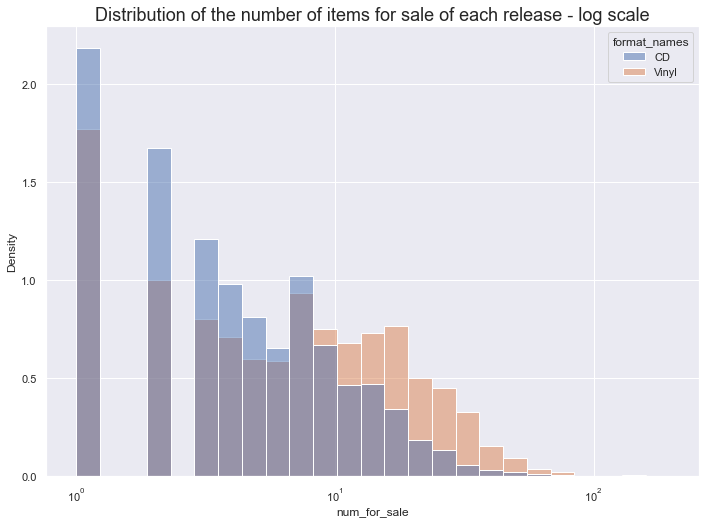

In [33]:
ax= sns.histplot(data= raw_df, x=  1 +raw_df.num_for_sale, hue='format_names', bins=25,
                 stat='density', common_norm=False, log_scale=True);
plt.title('Distribution of the number of items for sale of each release - log scale', fontsize=18);

In [24]:
raw_df.lowest_price.describe()

count    24019.000000
mean         9.286509
std         26.413123
min          0.010000
25%          2.430000
50%          4.900000
75%          9.490000
max       2364.440000
Name: lowest_price, dtype: float64

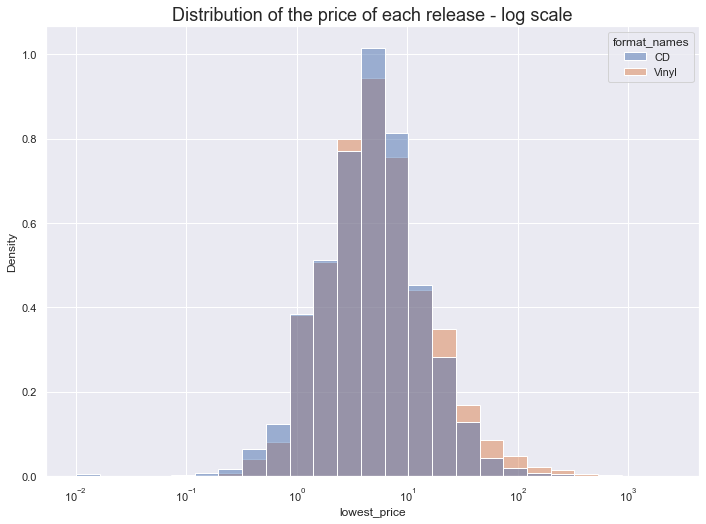

In [26]:
ax= sns.histplot(data= raw_df, x=raw_df.lowest_price, hue='format_names', bins=25,
                 stat='density', common_norm=False, log_scale=True);
plt.title('Distribution of the price of each release - log scale', fontsize=18);

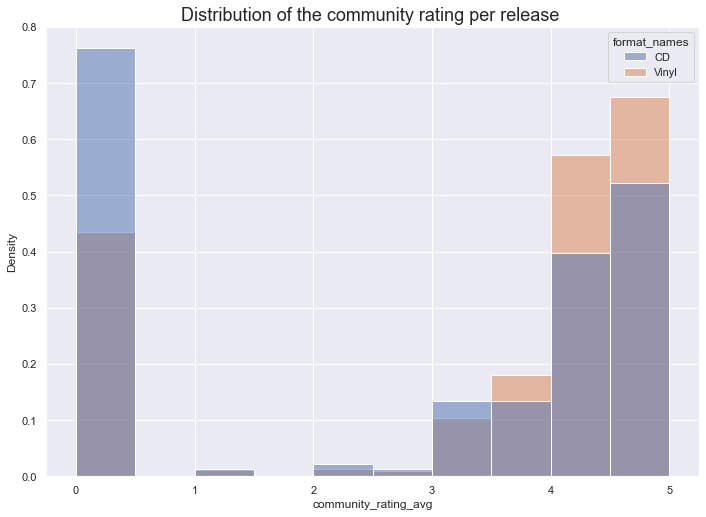

In [29]:
ax= sns.histplot(data= raw_df, x=raw_df.community_rating_avg, hue='format_names', bins=10,
                 stat='density', common_norm=False, log_scale=False);
plt.title('Distribution of the community rating per release ', fontsize=18);

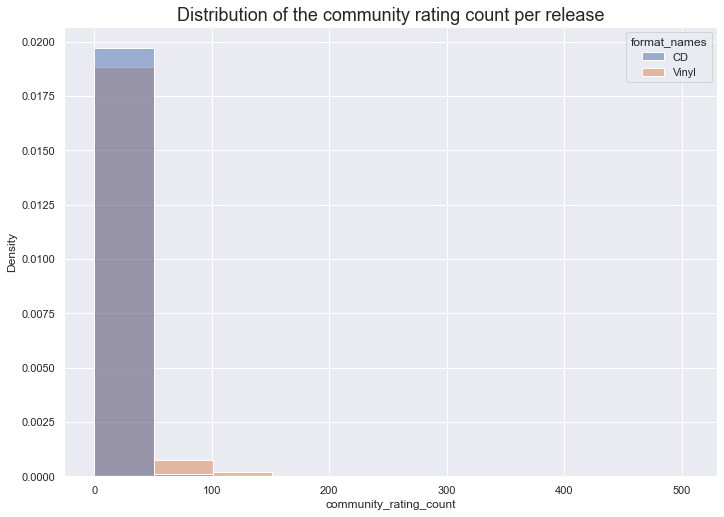

In [30]:
ax= sns.histplot(data= raw_df, x= raw_df.community_rating_count, hue='format_names', bins=10,
                 stat='density', common_norm=False, log_scale=False);
plt.title('Distribution of the community rating count per release', fontsize=18);

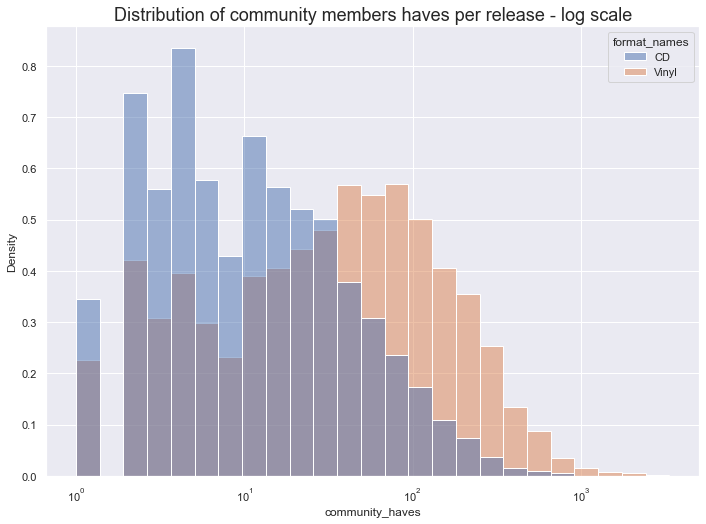

In [31]:
ax= sns.histplot(data= raw_df, x= 1 + raw_df.community_haves, hue='format_names', bins=25,
                 stat='density', common_norm=False, log_scale=True);
plt.title('Distribution of community members haves per release - log scale', fontsize=18);

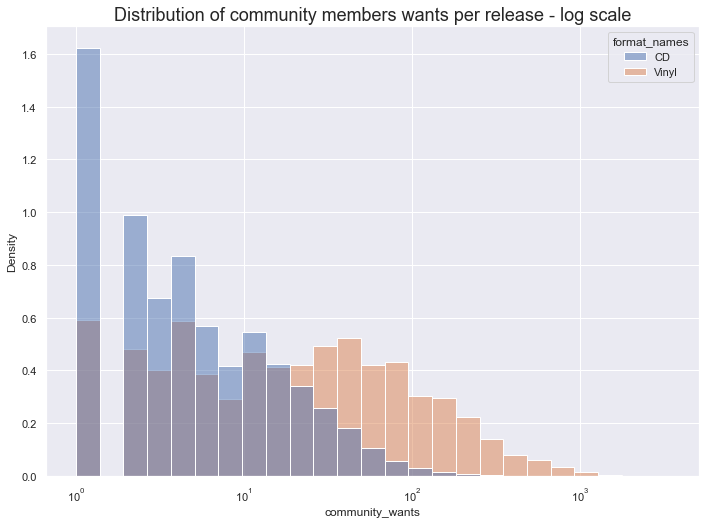

In [34]:
ax= sns.histplot(data= raw_df, x= 1 + raw_df.community_wants, hue='format_names', bins=25,
                 stat='density', common_norm=False, log_scale=True);
plt.title('Distribution of community members wants per release - log scale', fontsize=18);

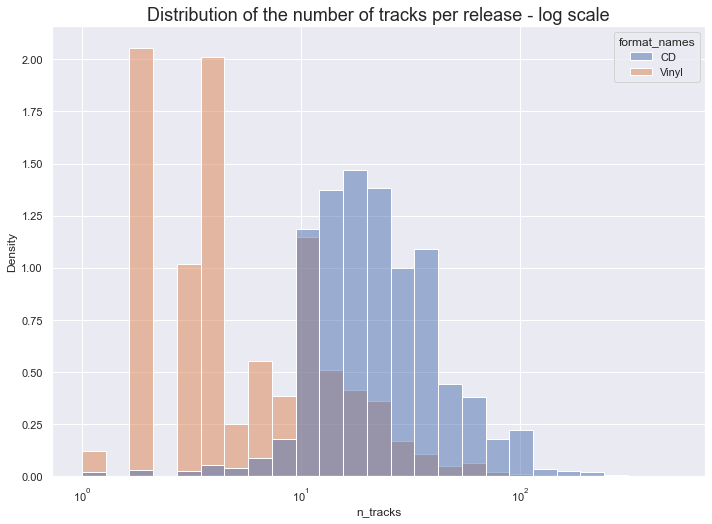

In [35]:
ax= sns.histplot(data= raw_df, x=raw_df.n_tracks, hue='format_names', bins=25,
                 stat='density', common_norm=False, log_scale=True);
plt.title('Distribution of the number of tracks per release - log scale', fontsize=18);

## Correlations

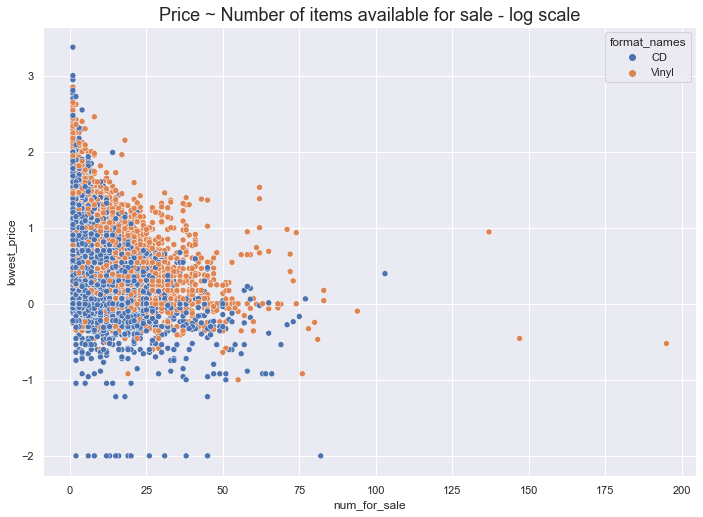

In [36]:
ax = sns.scatterplot(x='num_for_sale', y=np.log10(raw_df.lowest_price), hue='format_names', data=raw_df)
plt.title('Price ~ Number of items available for sale - log scale', fontsize=18);

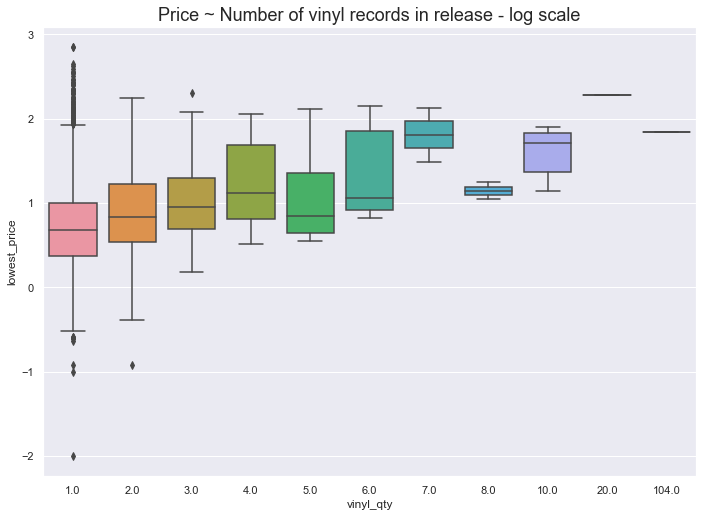

In [37]:
ax = sns.boxplot(x='vinyl_qty', y=np.log10(raw_df.lowest_price), data=raw_df)
plt.title('Price ~ Number of vinyl records in release - log scale', fontsize=18);

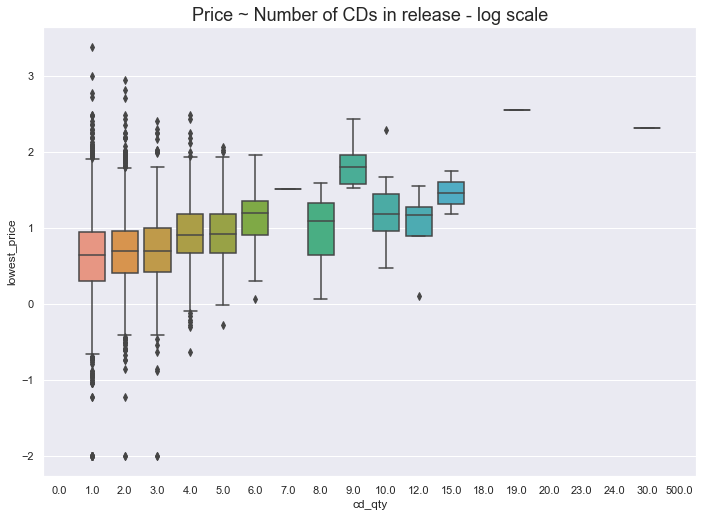

In [38]:
ax = sns.boxplot(x='cd_qty', y=np.log10(raw_df.lowest_price), data=raw_df)
plt.title('Price ~ Number of CDs in release - log scale', fontsize=18);

In [39]:
raw_df[['id', 'country']].groupby('country').nunique().sort_values('id', ascending=False).head(10)

,id
country,
UK,5433
US,4551
Germany,3196
France,1725
Netherlands,1516
Europe,1498
Japan,1290
Italy,1190
Belgium,836


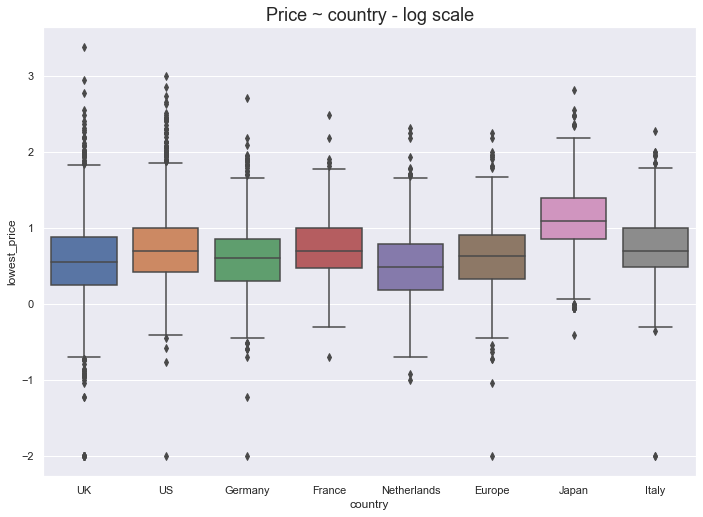

In [40]:
ax = sns.boxplot(x='country', y=np.log10(raw_df.loc[raw_df.country.isin(['UK', 'US', 'Germany', 'France', 'Netherlands', 'Europe', 'Japan', 'Italy'])].lowest_price),
                 data=raw_df.loc[raw_df.country.isin(['UK', 'US', 'Germany', 'France', 'Netherlands', 'Europe', 'Japan', 'Italy'])],
                 order=['UK', 'US', 'Germany', 'France', 'Netherlands', 'Europe', 'Japan', 'Italy']
                )
plt.title('Price ~ country - log scale', fontsize=18);

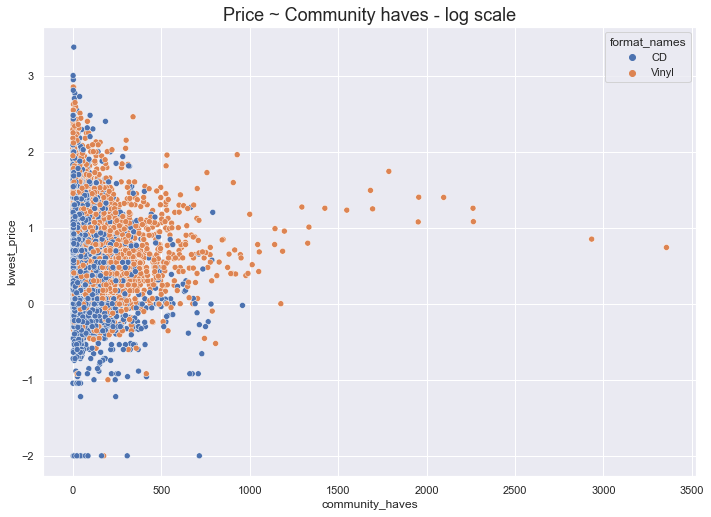

In [41]:
ax = sns.scatterplot(x='community_haves', y=np.log10(raw_df.lowest_price), hue='format_names', data=raw_df)
plt.title('Price ~ Community haves - log scale', fontsize=18);

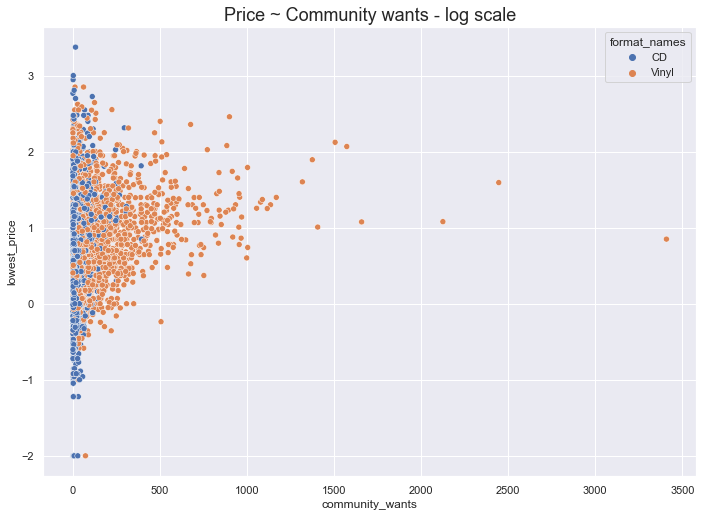

In [42]:
ax = sns.scatterplot(x='community_wants', y=np.log10(raw_df.lowest_price), hue='format_names', data=raw_df)
plt.title('Price ~ Community wants - log scale', fontsize=18);

## Creating desirability metrics

In [43]:
raw_df['desirability'] = raw_df.community_wants - raw_df.community_haves
raw_df['desirability_ratio'] = (raw_df.community_wants - raw_df.community_haves)/(1+ raw_df.community_haves)

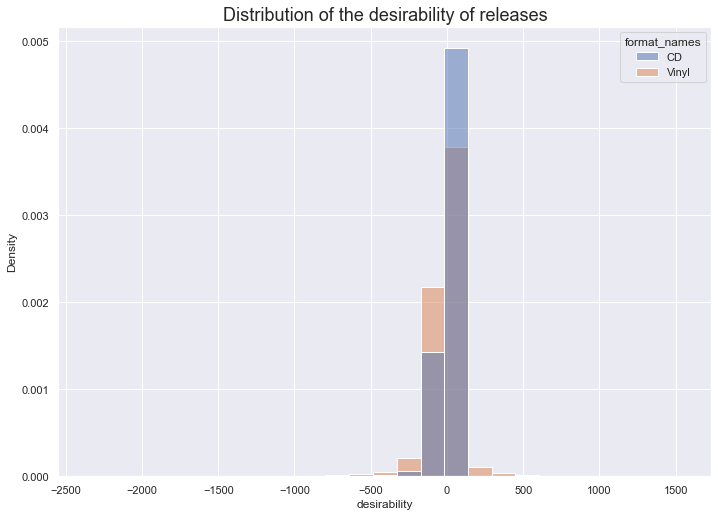

In [44]:
ax= sns.histplot(data= raw_df, x=raw_df.desirability, hue='format_names', bins=25,
                 stat='density', common_norm=False, log_scale=False);
plt.title('Distribution of the desirability of releases', fontsize=18);

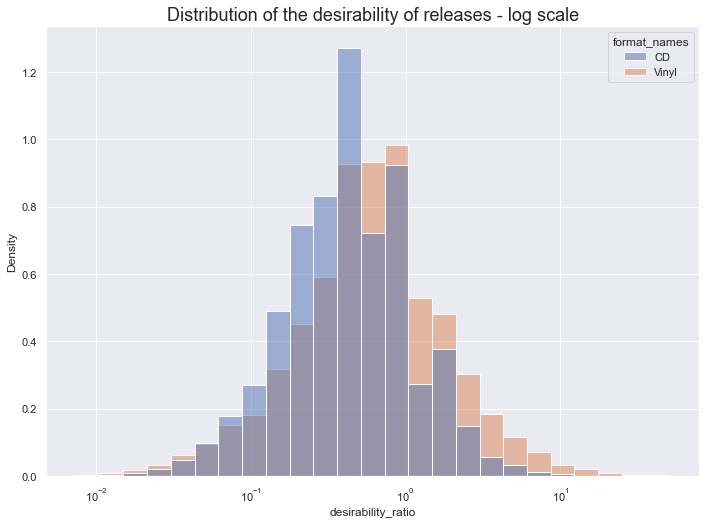

In [45]:
ax= sns.histplot(data= raw_df, x=1+raw_df.desirability_ratio, hue='format_names', bins=25,
                 stat='density', common_norm=False, log_scale=True);
plt.title('Distribution of the desirability of releases - log scale', fontsize=18);

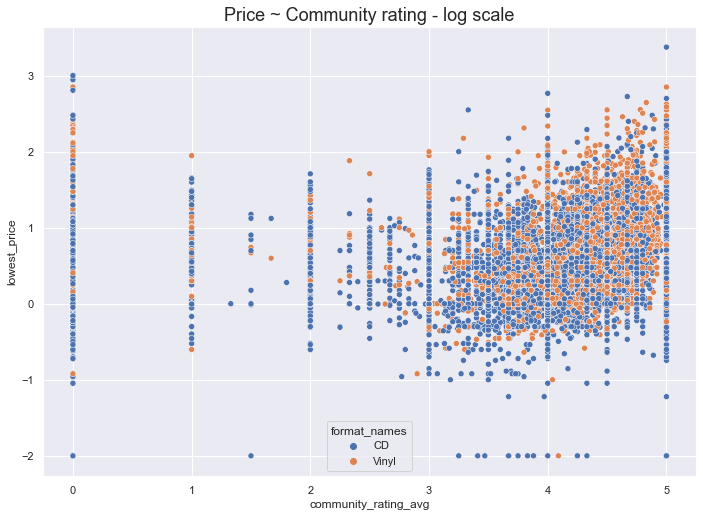

In [46]:
ax = sns.scatterplot(x=raw_df.community_rating_avg, y=np.log10(raw_df.lowest_price), hue='format_names', data=raw_df)
plt.title('Price ~ Community rating - log scale', fontsize=18);

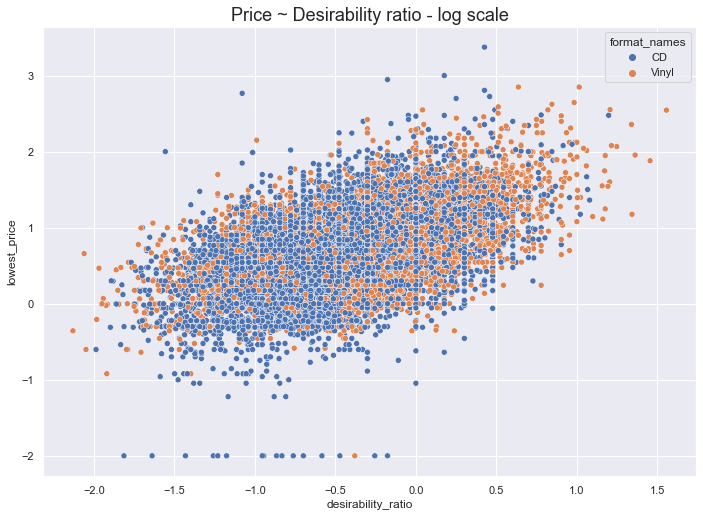

In [47]:
ax = sns.scatterplot(x=np.log10(1 + raw_df.desirability_ratio), y=np.log10(raw_df.lowest_price), hue='format_names', data=raw_df)
plt.title('Price ~ Desirability ratio - log scale', fontsize=18);

## Further preprocessing

In [48]:
raw_df.genres.fillna("[None]")
raw_df.styles.fillna("[None]")

2                                 ['Future Jazz', 'Latin']
3            ['Glitch', 'Techno', 'Minimal', 'Deep House']
4                      ['Soul', 'Rhythm & Blues', 'Disco']
5                                                   [None]
8                         ['Tech House', 'Minimal Techno']
                               ...                        
39072                           ['Soul', 'Rhythm & Blues']
39075                     ['House', 'Trance', 'Eurodance']
39076                                ['Contemporary Jazz']
39077    ['Jazzy Hip-Hop', 'Conscious', 'Soul', 'RnB/Sw...
39078    ['Bop', 'Dixieland', 'Swing', 'Big Band', 'Coo...
Name: styles, Length: 29667, dtype: object

In [49]:
raw_df['genres'] = raw_df.genres.fillna("[None]").apply(ast.literal_eval)
raw_df['styles'] = raw_df.styles.fillna("[None]").apply(ast.literal_eval)

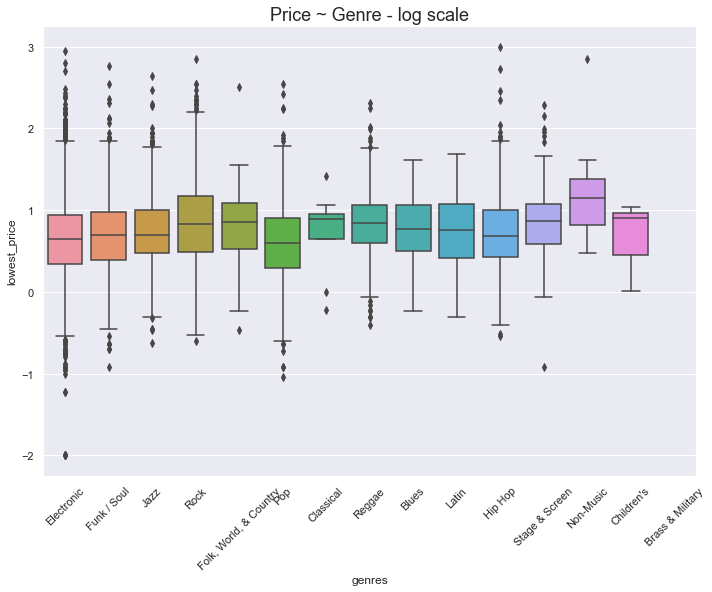

In [53]:
ax = sns.boxplot(x=raw_df.loc[raw_df.genres.str.len()==1].genres.str[0], 
                 y=np.log10(raw_df.loc[raw_df.genres.str.len()==1].lowest_price), 
                 data=raw_df.loc[raw_df.genres.str.len()==1])
plt.title('Price ~ Genre - log scale', fontsize=18);
plt.xticks(rotation=45);

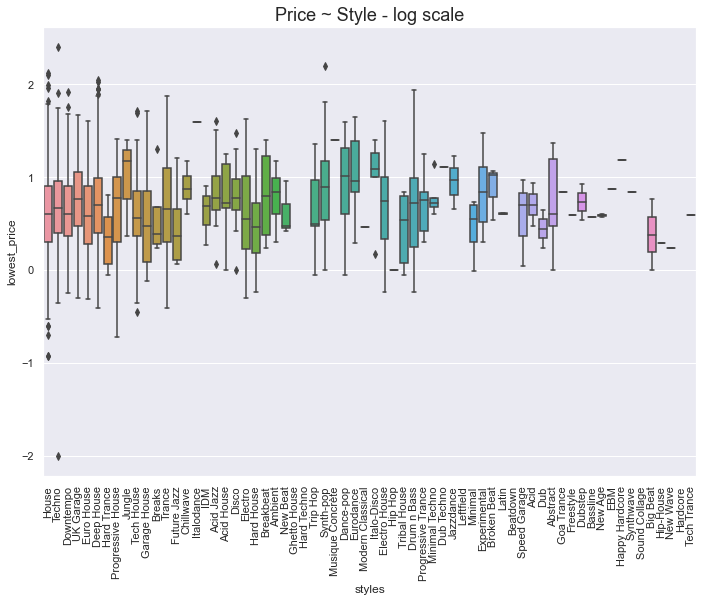

In [54]:
ax = sns.boxplot(x=raw_df.loc[(raw_df.styles.str.len()==1)&(raw_df.genres.str.len()==1)&(raw_df.genres.str[0] == 'Electronic')].styles.str[0], 
                 y=np.log10(raw_df.loc[(raw_df.styles.str.len()==1)&(raw_df.genres.str.len()==1)&(raw_df.genres.str[0] == 'Electronic')].lowest_price), 
                 data=raw_df.loc[(raw_df.styles.str.len()==1)&(raw_df.genres.str.len()==1)&(raw_df.genres.str[0] == 'Electronic')])
plt.title('Price ~ Style - log scale', fontsize=18);
plt.xticks(rotation=90);

In [63]:
raw_df.head(1).T

,2
id,2418890
status,Accepted
resource_url,https://api.discogs.com/releases/2418890
title,A History Of Schema: Numero Due
artists_sort,Various
num_for_sale,0
date_added,2010-08-28T12:10:51-07:00
lowest_price,NaN
released,2007
country,Japan


In [58]:
raw_df.shape

(29667, 32)

In [56]:
pd.get_dummies(raw_df.genres.apply(pd.Series).stack()).sum(level=0)

/var/folders/8f/gnkzhpdx2sbg2m3q91g47bpc0000gn/T/ipykernel_18392/494184881.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.get_dummies(raw_df.genres.apply(pd.Series).stack()).sum(level=0)


,Blues,Brass & Military,Children's,Classical,Electronic,"Folk, World, & Country",Funk / Soul,Hip Hop,Jazz,Latin,Non-Music,Pop,Reggae,Rock,Stage & Screen
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39072,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
39075,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
39076,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
39077,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0


## Linear regression model
### Building the dataset

In [64]:
raw_df['years_since_release'] = 2021- raw_df.release_year.fillna(raw_df.year_added).astype(int)

In [65]:
raw_df.head(1).T

,2
id,2418890
status,Accepted
resource_url,https://api.discogs.com/releases/2418890
title,A History Of Schema: Numero Due
artists_sort,Various
num_for_sale,0
date_added,2010-08-28T12:10:51-07:00
lowest_price,NaN
released,2007
country,Japan


In [66]:
raw_df['item_qty'] = raw_df.vinyl_qty.fillna(raw_df.cd_qty)

In [92]:
clean_df = raw_df[[
    'num_for_sale', 'lowest_price', 'estimated_weight', 'format_names', 'item_qty', 'genres', 'styles',
    'community_haves', 'community_wants', 'community_rating_count', 'community_rating_avg', 'n_tracks', 
    'days_since_added', 'years_since_release', 'desirability_ratio'
            ]].reset_index(drop=True)

In [93]:
clean_df.dropna(inplace=True)
clean_df.reset_index(drop=True, inplace=True)

In [94]:
clean_df.isnull().sum()

num_for_sale              0
lowest_price              0
estimated_weight          0
format_names              0
item_qty                  0
genres                    0
styles                    0
community_haves           0
community_wants           0
community_rating_count    0
community_rating_avg      0
n_tracks                  0
days_since_added          0
years_since_release       0
desirability_ratio        0
dtype: int64

### Feature engineering
#### Format names

In [171]:
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer

In [236]:
df = clean_df.copy()

In [237]:
jobs_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [238]:
jobs_encoder.fit(df['format_names'].to_numpy().reshape(-1, 1))
transformed = jobs_encoder.transform(df['format_names'].to_numpy().reshape(-1, 1))

ohe_df = pd.DataFrame(transformed, columns=jobs_encoder.get_feature_names_out())
df = pd.concat([df, ohe_df], axis=1).drop('format_names', axis=1).reset_index(drop=True)

In [291]:
jobs_encoder.get_feature_names_out()

array(['x0_Vinyl'], dtype=object)

In [239]:
ohe_df.shape

(24019, 1)

In [240]:
df.shape

(24019, 15)

In [241]:
df.isnull().sum()

num_for_sale              0
lowest_price              0
estimated_weight          0
item_qty                  0
genres                    0
styles                    0
community_haves           0
community_wants           0
community_rating_count    0
community_rating_avg      0
n_tracks                  0
days_since_added          0
years_since_release       0
desirability_ratio        0
x0_Vinyl                  0
dtype: int64

In [242]:
df.columns

Index(['num_for_sale', 'lowest_price', 'estimated_weight', 'item_qty',
       'genres', 'styles', 'community_haves', 'community_wants',
       'community_rating_count', 'community_rating_avg', 'n_tracks',
       'days_since_added', 'years_since_release', 'desirability_ratio',
       'x0_Vinyl'],
      dtype='object')

In [243]:
df.head(2)

,num_for_sale,lowest_price,estimated_weight,item_qty,genres,styles,community_haves,community_wants,community_rating_count,community_rating_avg,n_tracks,days_since_added,years_since_release,desirability_ratio,x0_Vinyl
0,18,1.77,230.0,1.0,[Electronic],"[Glitch, Techno, Minimal, Deep House]",146,47,17,4.12,4,6403,18,-0.673469,1.0
1,1,7.06,85.0,1.0,[Funk / Soul],"[Soul, Rhythm & Blues, Disco]",1,0,0,0.00,12,154,14,-0.500000,0.0


#### Genres

In [244]:
ohe_df = pd.get_dummies(df.genres.apply(pd.Series).stack()).groupby(level=0).sum()
df = pd.concat([df, ohe_df.drop(ohe_df.columns[0], axis=1)], axis=1).drop(['genres'], axis=1).reset_index(drop=True)

In [245]:
ohe_df.shape

(24019, 15)

In [246]:
df.shape

(24019, 28)

In [247]:
df.isnull().sum().sum()

0

In [248]:
df.head(2)

,num_for_sale,lowest_price,estimated_weight,item_qty,styles,community_haves,community_wants,community_rating_count,community_rating_avg,n_tracks,...,"Folk, World, & Country",Funk / Soul,Hip Hop,Jazz,Latin,Non-Music,Pop,Reggae,Rock,Stage & Screen
0,18,1.77,230.0,1.0,"[Glitch, Techno, Minimal, Deep House]",146,47,17,4.12,4,...,0,0,0,0,0,0,0,0,0,0
1,1,7.06,85.0,1.0,"[Soul, Rhythm & Blues, Disco]",1,0,0,0.00,12,...,0,1,0,0,0,0,0,0,0,0


### Styles

In [249]:
temp = pd.get_dummies(df.styles.apply(pd.Series).stack()).groupby(level=0).sum()

In [250]:
temp.shape

(19628, 393)

In [251]:
temp.isnull().sum().sum()

0

In [252]:
ohe_df = pd.get_dummies(df.styles.apply(pd.Series).stack()).groupby(level=0).sum()
df = (
    df.merge(ohe_df.drop(ohe_df.columns[0], axis=1), right_index=True, left_index=True, how='left')
    .drop(['styles'], axis=1)
    .reset_index(drop=True)
)

In [253]:
392+27

419

In [254]:
ohe_df.drop(ohe_df.columns[0], axis=1).columns

Index(['Abstract', 'Acid', 'Acid House', 'Acid Jazz', 'Acid Rock', 'Acoustic',
       'African', 'Afro-Cuban', 'Afro-Cuban Jazz', 'Afrobeat',
       ...
       'UK Street Soul', 'Video Game Music', 'Viking Metal', 'Vocal',
       'Volksmusik', 'Western Swing', 'Yé-Yé', 'Zouk', 'Zydeco', 'Éntekhno'],
      dtype='object', length=392)

In [227]:
df.shape

(24019, 419)

In [255]:
df.isnull().sum().sum()

1721272

In [256]:
392*(24019-19628)

1721272

In [258]:
df.fillna(0, inplace=True)

In [259]:
df.isnull().sum().sum()

0

## Creating a preprocessing pipeline

In [371]:
def preprocess_dataset(df: pd.DataFrame):
    df = df.reset_index(drop=True)
    jobs_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
    
    ## One hot encoding of format names
    jobs_encoder.fit(df['format_names'].to_numpy().reshape(-1, 1))
    transformed = jobs_encoder.transform(df['format_names'].to_numpy().reshape(-1, 1))
    ohe_df = pd.DataFrame(transformed, columns=jobs_encoder.get_feature_names_out())
    df = pd.concat([df, ohe_df], axis=1, ).drop('format_names', axis=1).reset_index(drop=True)
    
    format_cols = ohe_df.columns
    ## One hot encoding of genres
    ohe_df = pd.get_dummies(df.genres.apply(pd.Series).stack()).groupby(level=0).sum().add_prefix('genre_')
    df = (
        df.merge(ohe_df, right_index=True, left_index=True, how='left')
        .drop(['genres'], axis=1).reset_index(drop=True)
    )
    
    genre_cols = ohe_df.columns
    ## one hot encoding of styles
    ohe_df = pd.get_dummies(df.styles.apply(pd.Series).stack()).groupby(level=0).sum().add_prefix('style_')
    df = (
        df.merge(ohe_df, right_index=True, left_index=True, how='left')
        .drop(['styles'], axis=1).reset_index(drop=True)
    )
    style_cols = ohe_df.columns
    df.fillna(0, inplace=True)
    return df, format_cols, genre_cols, style_cols

## Splitting

In [372]:
from sklearn.model_selection import train_test_split

In [373]:
clean_df.head(1)

,num_for_sale,lowest_price,estimated_weight,format_names,item_qty,genres,styles,community_haves,community_wants,community_rating_count,community_rating_avg,n_tracks,days_since_added,years_since_release,desirability_ratio
0,18,1.77,230.0,Vinyl,1.0,[Electronic],"[Glitch, Techno, Minimal, Deep House]",146,47,17,4.12,4,6403,18,-0.673469


In [428]:
X_train, X_test, y_train, y_test = train_test_split(clean_df.drop(['lowest_price'], axis=1), clean_df.lowest_price, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

In [429]:
X_train, format_cols, genre_cols, style_cols = preprocess_dataset(df=X_train)
X_test, test_format_cols, test_genre_cols, test_style_cols = preprocess_dataset(df=X_test)
# X_val = preprocess_dataset(df=X_val)

## Creating pipeline

In [377]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [378]:
numeric_features = [
    "num_for_sale", "estimated_weight", "item_qty", 
    "community_haves", "community_wants", "community_rating_avg",
    "n_tracks", "days_since_added", "years_since_release", "desirability_ratio"
                   ]
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

In [435]:
boolean_features = [*format_cols, *genre_cols]
boolean_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

In [436]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", boolean_transformer, boolean_features),
    ]
)

In [437]:
regressor = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression(fit_intercept=True))]
)


In [438]:
'Classical' in X_train.columns

False

In [439]:
'Classical' in format_cols

False

In [446]:
regressor.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['num_for_sale',
                                                   'estimated_weight',
                                                   'item_qty',
                                                   'community_haves',
                                                   'community_wants',
                                                   'community_rating_avg',
                                                   'n_tracks',
                                                   'days_since_added',
                                                   'years_since_release',
                                                   'desirability_ratio']),
                                              

In [447]:
fitted_lr_model = regressor.named_steps['regressor']

In [451]:
regressor.score(X_test, y_test)

0.05619621800538288

In [452]:
coeff_interpretation_df = pd.DataFrame()
coeff_interpretation_df['feature_name'] = preprocessor.get_feature_names_out()
coeff_interpretation_df['coefficient'] = fitted_lr_model.coef_

In [454]:
fitted_lr_model.intercept_

9.276310457289572

In [455]:
coeff_interpretation_df.sort_values('coefficient', ascending=True).head(10)

,feature_name,coefficient
0,num__num_for_sale,-2.651817
7,num__days_since_added,-2.260452
1,num__estimated_weight,-1.372155
15,cat__genre_Electronic,-1.214006
22,cat__genre_Pop,-1.083256
23,cat__genre_Reggae,-0.573057
17,cat__genre_Funk / Soul,-0.549525
19,cat__genre_Jazz,-0.433357
11,cat__genre_Blues,-0.267740
13,cat__genre_Children's,-0.035794


In [456]:
coeff_interpretation_df.sort_values('coefficient', ascending=False).head(10)

,feature_name,coefficient
9,num__desirability_ratio,7.158849
2,num__item_qty,2.653400
5,num__community_rating_avg,1.329440
21,cat__genre_Non-Music,1.224156
3,num__community_haves,0.982280
4,num__community_wants,0.919167
10,cat__x0_Vinyl,0.915043
24,cat__genre_Rock,0.877422
6,num__n_tracks,0.784405
8,num__years_since_release,0.489117


In [457]:
format_cols

Index(['x0_Vinyl'], dtype='object')

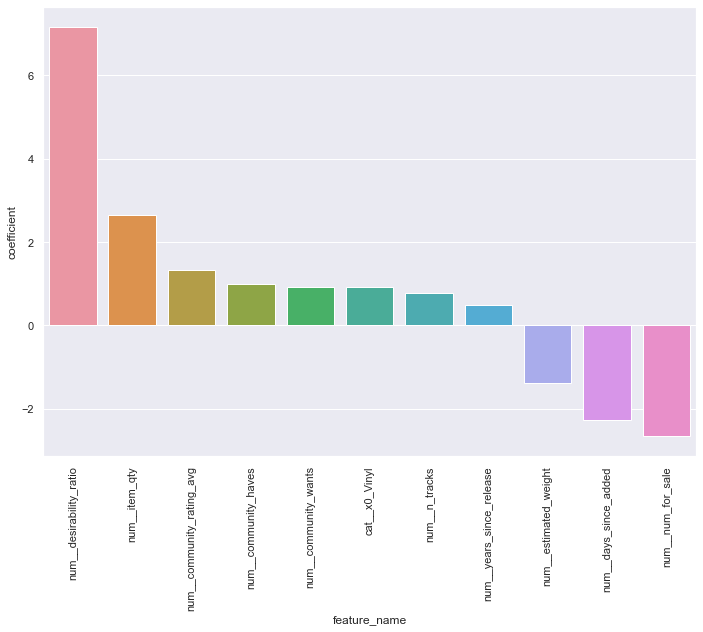

In [458]:
sns.barplot(
    data=(
        coeff_interpretation_df
        .loc[coeff_interpretation_df.feature_name.str.startswith('num__')|coeff_interpretation_df.feature_name.str.contains('Vinyl')]
        .sort_values('coefficient', ascending=False)
    ),
    x='feature_name', y='coefficient'
)
plt.xticks(rotation=90);

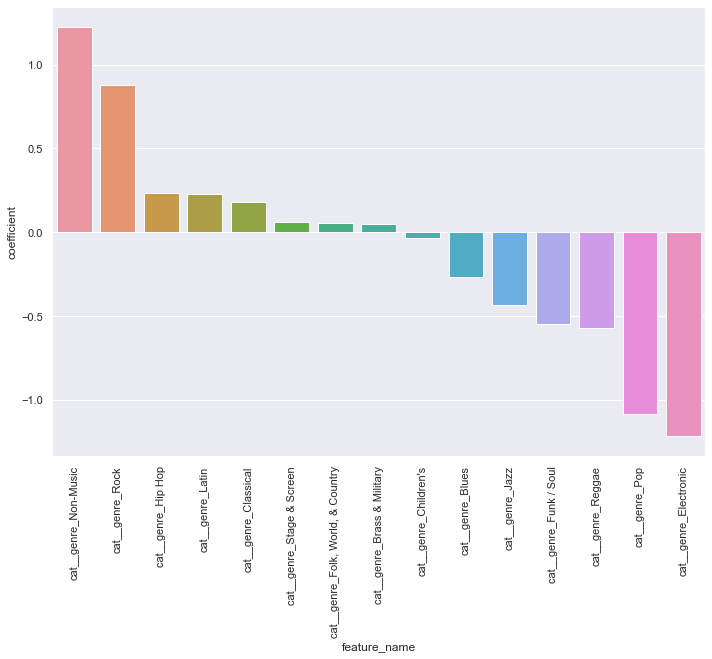

In [459]:
sns.barplot(
    data=(
        coeff_interpretation_df
        .loc[coeff_interpretation_df.feature_name.str.startswith('cat__genre_')]
        .sort_values('coefficient', ascending=False)
    ),
    x='feature_name', y='coefficient'
)
plt.xticks(rotation=90);